In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)

2001


In [3]:
retis = storage.transitions.load(0)
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [4]:
retis.rate(storage)

2.816201113604415e-05

In [5]:
%%time
retis.move_summary(storage)
print

pathreversal ran 21.7923059818% of the cycles with acceptance 1352/1960 (0.689795918367) 
shooting ran 45.0967311541% of the cycles with acceptance 3036/4056 (0.748520710059) 
minus ran 0.700466977985% of the cycles with acceptance 63/63 (1.0) 
repex ran 21.1251945742% of the cycles with acceptance 732/1900 (0.385263157895) 

CPU times: user 576 ms, sys: 46.3 ms, total: 623 ms
Wall time: 618 ms


In [6]:
%%time
retis.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 4 ran 6.58216588837% of the cycles with acceptance 440/592 (0.743243243243) 
OneWayShootingMover I'face 2 ran 7.56059595286% of the cycles with acceptance 496/680 (0.729411764706) 
OneWayShootingMover I'face 5 ran 7.29375138982% of the cycles with acceptance 444/656 (0.676829268293) 
OneWayShootingMover I'face 1 ran 8.58350011119% of the cycles with acceptance 612/772 (0.79274611399) 
OneWayShootingMover I'face 3 ran 8.09428507894% of the cycles with acceptance 524/728 (0.71978021978) 
OneWayShootingMover I'face 0 ran 6.98243273293% of the cycles with acceptance 520/628 (0.828025477707) 

CPU times: user 614 µs, sys: 294 µs, total: 908 µs
Wall time: 481 µs


In [7]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [8]:
first40 = first_n(storage, 40, trajid=4)

In [9]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 172 ms, sys: 29.8 ms, total: 202 ms
Wall time: 461 ms


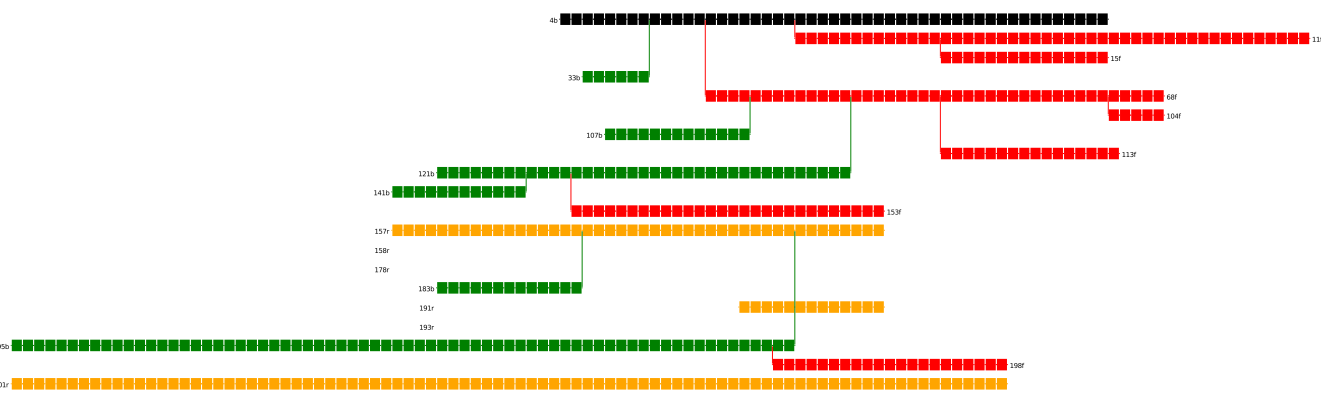

In [10]:
SVG(view.to_svg())

In [11]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 4 decorrelated trajectories.


In [12]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [13]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 27.8 s, sys: 2.02 s, total: 29.8 s
Wall time: 30.1 s


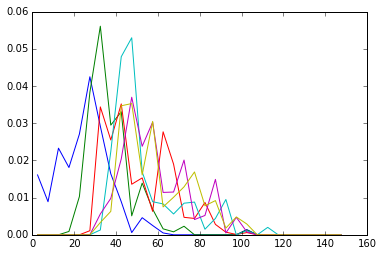

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    normalized = myhist.normalized()
    plt.plot(normalized.x, normalized)

In [20]:
np.log(myhist.reverse_cumulative())

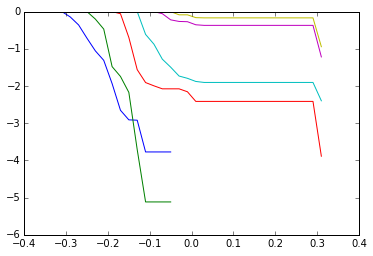

In [24]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    reverse_cumulative = myhist.reverse_cumulative()
    plt.plot(reverse_cumulative.x,
             np.log(reverse_cumulative.values())
            )

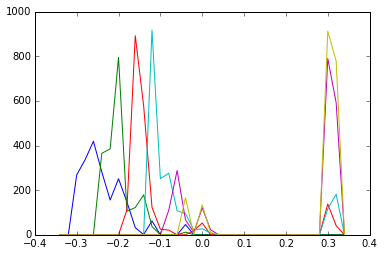

In [25]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]()
    plt.plot(myhist.x, myhist)

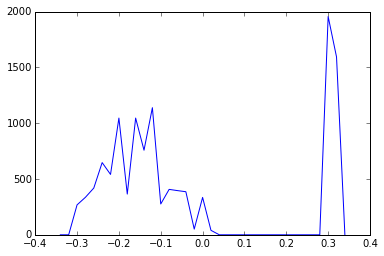

In [26]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.x, total_sampling);

In [27]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

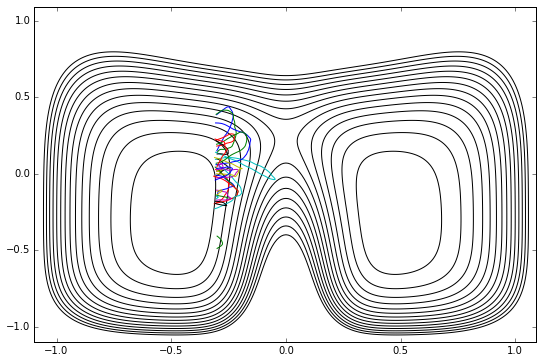

In [28]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [29]:
wham = retis.total_crossing_probability(method="wham")

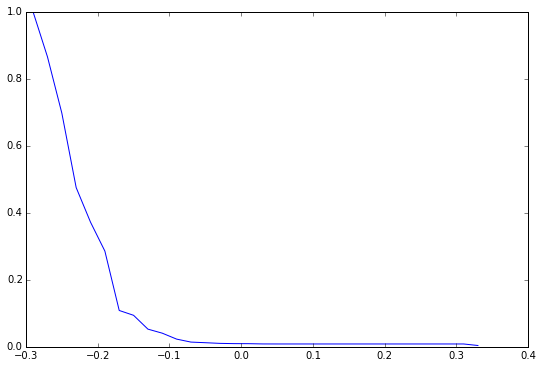

In [32]:
plt.plot(wham.x, wham.values());

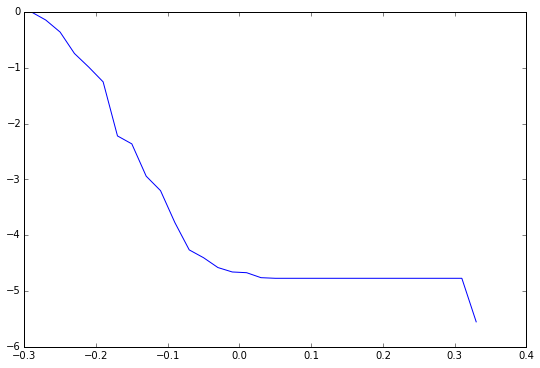

In [33]:
plt.plot(wham.x, np.log(wham.values()));

In [34]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 1.79 s, sys: 170 ms, total: 1.96 s
Wall time: 1.95 s


0.8450774612693653

In [35]:
retis.minus_move_flux(storage)

0.0027244421380384011

In [36]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.00272444213804 0.012231777096 0.845077461269
